# LHC_GW_CONV

Local Hill Climb Global Warming Convolution[1] search algorithm implemented in a discrete environment using jsim.

[1] L. Lin and M. A. Goodrich, ‘UAV intelligent path planning for wilderness search and rescue’, 2009 IEEE/RSJ International Conference on Intelligent Robots and Systems, IROS 2009, vol. 0, no. 1, pp. 709–714, 2009, doi: [10.1109/IROS.2009.5354455.](https://doi.org/10.1109/IROS.2009.5354455)

In [1]:
import sys, os

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

In [2]:
import numpy as np
from scipy import signal as sps
import matplotlib.pyplot as plt
from loguru import logger
from typing import List, Tuple
from copy import copy

In [3]:
logger.remove()
if os.environ.get('DEBUG', False):
    logger.add(sys.stderr, level="DEBUG")
else:
    logger.add(sys.stderr, level="INFO")

In [4]:
# Install from package at https://github.com/iwishiwasaneagle/jsim/releases/latest or add use it from within the project
from jsim.Simulation import Simulation
from jsim.Agent import Agent
from jsim.Environment import Environment
from jsim.Meta import Action, State

In [5]:
class XYState(State):
    def __init__(self,x:float=0,y:float=0) -> None:
        self.x = x
        self.y = y
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self.x}, {self.y})"

class Position(XYState):
    pass

In [6]:
class VicinityPDM(State):
    def __init__(self, vicinity: List, m: int = 3) -> None:
        """
        A slice of the PDM centered at the agent's location

        Indices for a m=3 vicinity PDM:

            -------------
            | 0 | 1 | 2 |
            | - | - | - |
            | 3 | 4 | 5 |
            | - | - | - |
            | 6 | 7 | 8 |
            -------------

        :param vicinity: The PDM values in the 3x3 area around the agent
        :type vicinity: List
        :param m: Size of the vicinity such that it is a m x m square. Can be (3,5,7,9). Default: 3
        :type m: int
        """
        assert m in (3,5,7,9)
        assert len(vicinity) == m*m
        self._vicinity = vicinity
        self._m = m

    def __len__(self):
        return len(self._vicinity)

    def __getitem__(self, idx):
        assert 0 <= idx <= (self._m ** 2) - 1
        assert isinstance(idx,int)

        return self._vicinity[idx]

    def __iter__(self):
        if not hasattr(self, '_c'):
            self._c = -1
        return self

    def __next__(self):
        self._c += 1
        if self._c >= len(self):
            raise StopIteration
        return self._vicinity[self._c]
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self._vicinity})"

assert max(VicinityPDM([1,2,3,10,5,6,7,8,9])) == 10
assert max(VicinityPDM([1,2,3,10,5,6,7,8,9,1,1,1,2,3,1,2,1,3,6,7,8,2,3,4,5],m=5)) == 10

In [7]:
class Step(Action):
    def __init__(self, idx:int) -> None:
        self.idx = int(idx)
        lookup = [
            (-1,  1),
            ( 0,  1),
            ( 1,  1),
            (-1,  0),
            ( 0,  0),
            ( 1,  0),
            (-1, -1),
            ( 0, -1),
            ( 1, -1),
            ]
        self.rel_x, self.rel_y = lookup[self.idx]
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self.rel_x},{self.rel_y})"

    def __eq__(self, other):
        assert isinstance(other, self.__class__)
        return other.idx == self.idx

def test():
    assert Step(0) == Step(0)
    assert Step(6) != Step(7)

    try:
        Step(0) == 1
        assert False
    except AssertionError:
        assert True
test()

In [8]:
class PDMEnv(Environment):
    def __init__(self, m: int = 16, n_gauss:int = 5, psim: Simulation = None) -> None:
        super().__init__(psim=psim)

        self._shape = (m,m)

        self.pdm = self._generate_pdm(n = n_gauss)

    @property
    def shape(self):
        return self._shape

    def _generate_pdm(self, n:int=5):
        x, y = np.meshgrid(np.arange(self.shape[0]), np.arange(self.shape[1]))

        pdm = np.zeros(self.shape)

        for _ in range(n): # Generate n gaussians
            A = max(np.random.rand()*2,1)
            a = np.random.rand()*0.03
            b = 0
            c = np.random.rand()*0.03
            x0 = np.random.uniform(0,self.shape[0]) # Centre of gaussian
            y0 = np.random.uniform(0,self.shape[1])
            
            pdm += A*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
                
        return pdm

    def _get_vicinity_at_xy(self,x:int,y:int,m:int=3) -> VicinityPDM:
        vicinity = np.empty(m*m)
        ij = np.meshgrid(np.arange(-m//2+1,m//2+1),np.flip(np.arange(-m//2+1,m//2+1))) # consult the VicinityPDM docs for why y is flipped and x isn't
        for idx,(i, j) in enumerate(
                    zip(
                        x+ij[0].flatten(),
                        y+ij[1].flatten()
                    )
                ):
            # Todo: does i corresponds to shape[0] or shape[1]?
            if i<0 or j<0 or i>=self.pdm.shape[0] or j>=self.pdm.shape[1]: 
                vicinity[idx] = -np.iinfo(np.int16).max
            else:
                vicinity[idx] = self.pdm[j][i]
        return VicinityPDM(vicinity,m=m)

    def reset(self, agent_p:Position) -> Position:
        self.pdm = self._generate_pdm()

        vicinity = self._get_vicinity_at_xy(agent_p.x, agent_p.y)

        return vicinity

    def step(self, agent_s: Position) -> Tuple[VicinityPDM, float]:
        assert agent_s.x >= 0 and agent_s.y >= 0

        reward = self.pdm[agent_s.y][agent_s.x]
        self.pdm[agent_s.y][agent_s.x] = -1

        env_s = self._get_vicinity_at_xy(agent_s.x,agent_s.y)

        return env_s, reward

def test():
    pdm = PDMEnv(m=25)
    pdm.pdm = np.zeros(pdm.shape)
    pdm.pdm[10,:] = 1.0

    for m in (3,5,7,9):
        for x in range(m//2,pdm.shape[0]-m//2):
            vpdm = pdm._get_vicinity_at_xy(x,9)
            assert all(vpdm._vicinity[:3] == 1.0)
            vpdm = pdm._get_vicinity_at_xy(x,10)
            assert all(vpdm._vicinity[3:6] == 1.0)
            vpdm = pdm._get_vicinity_at_xy(x,11)
            assert all(vpdm._vicinity[7:9] == 1.0)
test()

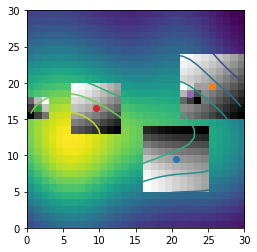

In [9]:
# Validate it works (visually)
def validate():
    pdm = PDMEnv(m=30, n_gauss=10)

    plt.imshow(pdm.pdm, origin='lower', extent=[0, pdm.shape[0], 0, pdm.shape[1]])

    for _ in range(5):
        m = np.random.choice([3,5,7,9])
        x,y = np.random.randint([m//2,m//2], [f-m//2 for f in pdm.shape],(2,))
        vpdm = pdm._get_vicinity_at_xy(x,y,m=m)
        vpdm = np.reshape(vpdm._vicinity,[m,m])

        z = np.zeros(pdm.shape)
        z[:] = np.nan

        y_lower = y-m//2
        y_upper = y+1+m//2
        x_lower = x-m//2
        x_upper = x+1+m//2

        z[ y_lower:y_upper, x_lower:x_upper] = vpdm
        plt.imshow(z,cmap='gray', origin='lower', extent=[0, pdm.shape[0], 0, pdm.shape[1]])
        plt.scatter(x+0.5,y+0.5)

    plt.contour(pdm.pdm, origin='lower', extent=[0, pdm.shape[0], 0, pdm.shape[1]])
    plt.clim(np.min(pdm.pdm), np.max(pdm.pdm))
    plt.show()
validate()

In [10]:
class LHC_GW_CONV_Agent(Agent):
    state: Position

    def __init__(self, penv: Environment = None) -> None:
        self.penv = penv


    def policy(self, pnext_s: VicinityPDM) -> Step:
        pdm = pnext_s._vicinity
        idx = np.argwhere(np.amax(pdm) == pdm).flatten()
        if idx.size > 1:
            # convolution if there is a tie break
            pnext_s = self.penv._get_vicinity_at_xy(self.state.x, self.state.y, m = 7)
            vpdm = pnext_s._vicinity.reshape((7,7))

            ######## REPLACE KERNEL HERE ########

            kernel = np.ones((5,5))

            #####################################
            kernel /= np.sum(kernel)
            assert kernel.shape == (5,5)
            assert vpdm.shape == (7,7)
            conv_vpdm = sps.convolve2d(vpdm, kernel, mode='valid').flatten()
            assert conv_vpdm.shape == (9,)

            idx_new = np.argwhere(np.amax(conv_vpdm) == conv_vpdm).flatten()

            logger.debug(f"{len(idx)} collisions detected. Resolved to {idx_new=}")
            idx = idx_new

        action = Step(idx[0])
        return action

    def step(self, pnext_s: VicinityPDM) -> Step:
        return self.policy(pnext_s)

    def update(self, pa: Step) -> Position:
        if not hasattr(self,'state'):
            logger.error(f"Reset has not been called as {hasattr(self,'state')=}")
            raise Exception

        self.state.x += pa.rel_x
        self.state.y += pa.rel_y

        return copy(self.state)
        
    def reset(self, ps: Position, vicinity: VicinityPDM) -> Tuple[Step, Position]:
        self.state = copy(ps)
        return self.policy(vicinity), self.state

def test():
    for i in range(9):
        vpdm = np.zeros(9)
        vpdm[i] = 1
        vpdm = VicinityPDM(vpdm)
        agent = LHC_GW_CONV_Agent()
        agent_a, _ = agent.reset(Position(), vpdm)
        assert agent_a.idx == i

    vpdm = VicinityPDM([0,1,0,0,0,0,0,0,0])
    agent = LHC_GW_CONV_Agent()
    agent_a, _ = agent.reset(Position(), vpdm)
    assert agent_a.rel_x == 0 and agent_a.rel_y == 1

    vpdm = VicinityPDM([0,0,0,0,0,1,0,0,0])
    agent = LHC_GW_CONV_Agent()
    agent_a, _ = agent.reset(Position(), vpdm)
    assert agent_a.rel_x == 1 and agent_a.rel_y == 0

    vpdm = VicinityPDM([0,0,0,0,0,0,1,0,0])
    agent = LHC_GW_CONV_Agent()
    agent_a, _ = agent.reset(Position(), vpdm)
    assert agent_a.rel_x == -1 and agent_a.rel_y == -1

    env = PDMEnv()
    env.pdm = np.ones((7,7))
    env.pdm[3,6] = 10
    env.pdm[6,6] = -10
    env.pdm[0,6] = -10
    pos = Position(3,3)
    vpdm = env._get_vicinity_at_xy(pos.x, pos.y)
    agent = LHC_GW_CONV_Agent(penv = env)
    agent_a, _ = agent.reset(pos, vpdm)
    assert agent_a == Step(5)
test()

In [11]:
class LHCSim(Simulation):
    agent: LHC_GW_CONV_Agent
    agent_a: Step
    agent_s: Position

    env: PDMEnv
    vicinity_pdm: VicinityPDM

    def __init__(self, initial_pos=Position(), dt=0.1) -> None:
        self.env = PDMEnv(m=16,psim=self)
        self.agent = LHC_GW_CONV_Agent(penv=self.env)
        self.dt = dt

        self.initial_agent_s = initial_pos

        self.data_store = {'env_s':[], 'agent_a':[], 'agent_s':[], 'reward':[]}
        super().__init__()

    def reset(self, env = None) -> None:
        if env is not None:
            self.vicinity_pdm = env.reset(self.initial_agent_s)
            self.agent_a, self.agent_s = self.agent.reset(self.initial_agent_s,self.vicinity_pdm)
        self.data_store = {'env_s':[], 'agent_a':[], 'agent_s':[], 'reward':[]}

    def steps(self, num_steps: int, num_l: int) -> None:
        l = 0
        l_store = {}
        for _ in range(num_l):
            local_env = copy(self.env)
            self.agent = LHC_GW_CONV_Agent(penv=local_env)
            local_env.pdm = np.clip(local_env.pdm, 0, None)
            self.reset(local_env)
            for _ in range(num_steps):
                vicinity_pdm, reward = local_env.step(self.agent_s)

                self.collect_data(vicinity_pdm, self.agent_a, self.agent_s, reward)

                agent_a = self.agent.step(vicinity_pdm)
                agent_s = self.agent.update(agent_a)

                self.agent_s = agent_s
                self.agent_a = agent_a
                self.vicinity_pdm = vicinity_pdm

            logger.debug(f"Maximum number of steps={num_steps} reached for {l=:.2f}")

            # calculate reward as if GW hadn't been applied
            xy = self.data_store['agent_s']
            cum_reward = 0
            for x,y in zip([f.x for f in xy], [f.y for f in xy]):
                cum_reward += self.env.pdm[y,x]
            self.data_store['cum_reward'] = cum_reward
            l_store[l] = copy(self.data_store)
            logger.debug(f"Cumulative reward for {l=:.2f} is {cum_reward=:.2f}")

            l += (1/num_l)

        best_path_key = max(l_store, key=lambda x: l_store[x].get('cum_reward',0))
        best_path = l_store[best_path_key]

        logger.info(f"Best path was found with l={best_path_key:.2f}")
        self.data_store['best_path'] = best_path
        self.data_store['l_store'] = l_store

    def collect_data(self, env_s: VicinityPDM, agent_a: Step, agent_s: Position, reward: float) -> None:
        self.data_store['env_s'].append(copy(env_s))
        self.data_store['agent_a'].append(copy(agent_a))
        self.data_store['agent_s'].append(copy(agent_s))
        self.data_store['reward'].append(copy(reward))

    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6), dpi=80)

        # Reward over time
        t = [t*self.dt for t in range(len(self.data_store['best_path']['env_s']))]
        ax1.plot(t,np.cumsum(self.data_store['best_path']['reward']))
        ax1.set_ylabel('Cumulative reward')
        ax1.set_xlabel('time (s)')

        # Show pdm and path
        x = [p.x+0.5 for p in self.data_store['best_path']['agent_s']]
        y = [p.y+0.5 for p in self.data_store['best_path']['agent_s']]

        pdm = self.env.pdm

        ax2.imshow(pdm, origin='lower', extent=[0, pdm.shape[0], 0, pdm.shape[1]])
        ax2.plot(x,y)
        ax2.scatter(x[0],y[0],label='Start')
        ax2.scatter(x[-1],y[-1],label='End')
        ax2.set_ylabel('y')
        ax2.set_xlabel('x')
        ax2.legend()

        fig.tight_layout()

        # Different rewards
        fig, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=80)
        l_store = self.data_store['l_store']

        y_pos = np.arange(len(l_store))
        ax1.bar(y_pos, [l_store[k]['cum_reward'] for k in l_store])
        ax1.set_xticks(y_pos[::5], [round(k,2) for k in l_store.keys()][::5])
        ax1.set_xlabel('l value')
        ax1.set_ylabel('cumulative reward')

        fig.tight_layout()

2021-12-16 10:50:12.159 | INFO     | __main__:steps:61 - Best path was found with l=0.22


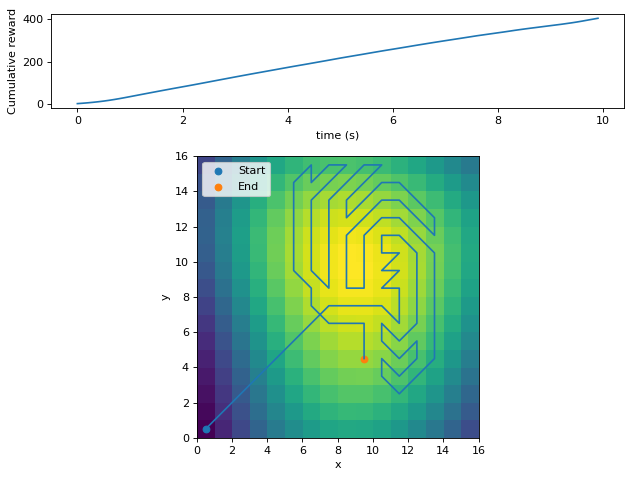

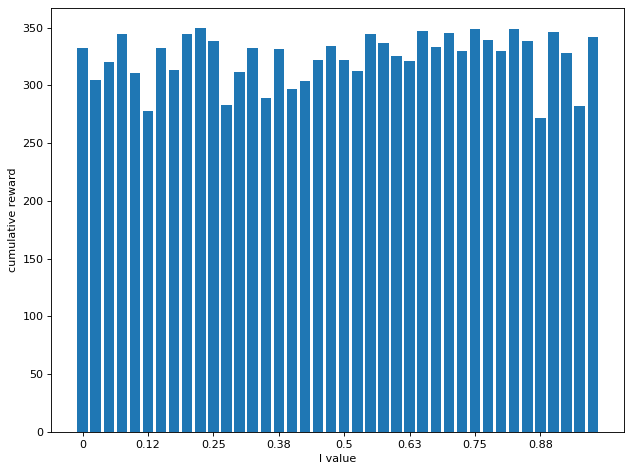

In [12]:
sim = LHCSim()

sim.steps(100, 40)

sim.plot()